In [689]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector
import numpy as np
import matplotlib.pyplot as plt

In [690]:
torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Consider 
$$
f^*(x) = \sum_{i=1}^{k} \sigma(v_i^\top x),
\quad \text{with } v_i \stackrel{iid}{\sim} \mathrm{Unif}(\mathbb{S}^{d-1})
$$

In [691]:
class TargetFunction(nn.Module):
    def __init__(self, d, k):
        super().__init__()
        v = torch.randn(k, d)
        v = v / v.norm(dim=1, keepdim=True) 
        self.register_buffer("v", v)

    def forward(self, x):
        return F.relu(x @ self.v.T).sum(dim=1)

$$f(x;\theta) = \sum_{j=1}^{m} a_j \sigma(w_j^\top x).$$
We consider a large initialization:
$a_j \sim \mathcal{N}(0,1),
\quad
w_j \sim \mathcal{N}\!\left(0, \dfrac{I_d}{\sqrt{d}}\right),$
for which the path norm at initialization satisfies
$\|\theta\|_{\mathcal{P}} \sim m.$

In [692]:
class TwoLayerReLU(nn.Module):
    def __init__(self, d, m):
        super().__init__()
        self.w = nn.Parameter(torch.randn(m, d) / d**0.25)
        self.a = nn.Parameter(torch.randn(m))

    def forward(self, x):
        return (F.relu(x @ self.w.T) * self.a.unsqueeze(0)).sum(dim=1)

We set $k = 10$, $d = 100$, $m = 100$, and the sample size $n = 300$.  
With this choice, the total number of parameters is $p = (d+1)m = 10100,$
and thus we are examining a highly over-parameterized regime where $p \gg n$.

In [693]:
k = 10
d = 100
m = 100
n = 300
n_test = 3000

In the code cell below we show the fact that $\|\theta\|_{\mathcal{P}} \sim m.$

In [719]:
for i in range(1, 6):
    model = TwoLayerReLU(d, m*i).to(device)
    path_norm = torch.sum(torch.abs(model.a) * model.w.norm(dim=1)).item()
    print(f"LR = {m*i:.4f}, path norm of parameters = {path_norm:.4f}")

LR = 100.0000, path norm of parameters = 249.2194
LR = 200.0000, path norm of parameters = 499.3785
LR = 300.0000, path norm of parameters = 717.0750
LR = 400.0000, path norm of parameters = 984.7678
LR = 500.0000, path norm of parameters = 1341.1840


We assume the input distribution to be $\rho=\mathrm{Unif}(\sqrt{d}\mathbb{S}^{d-1})$.

In [695]:
def sample_sphere(n, d, radius=1.0):
    x = torch.randn(n, d)
    x = x / x.norm(dim=1, keepdim=True) 
    return radius * x

In [696]:
f_star = TargetFunction(d, k).to(device)

X_train = sample_sphere(n, d, radius=d**0.5).to(device)
y_train = f_star(X_train).detach()

X_train, y_train = X_train.to(device), y_train.to(device)

X_test = sample_sphere(n_test, d, radius=d**0.5).to(device)
y_test = f_star(X_test).detach()

Then we define mesuarements of sharpness: $\mathrm{Tr}(G(\theta))$, $\|G(\theta)\|_2$, where $G(\theta)= \dfrac{1}{n} \sum \limits_{i=1}^{n} g_i(\theta) g_i(\theta)^T$ is the associate empirical Fisher matrix. And also define a measurement for parameters $\|\theta\|_{\mathcal{P}}$.

In [697]:
def test_error(model):
    with torch.no_grad():
        pred = model(X_test)
        return (torch.sign(pred) != torch.sign(y_test)).float().mean().item()

def calculate_metrics(model, X):
    dtype = next(model.parameters()).dtype
    device = next(model.parameters()).device

    X = X.to(device=device, dtype=dtype)

    trace_accum = 0.0
    n_samples = X.shape[0]

    params = list(model.parameters())

    for i in range(n_samples):
        out = model(X[i:i+1])

        grads = torch.autograd.grad(out,params,retain_graph=False,create_graph=False)

        total_norm_sq = sum(g.pow(2).sum() for g in grads)
        trace_accum += total_norm_sq.item()

    fisher_trace = trace_accum / n_samples

    path_norm = torch.sum(torch.abs(model.a) * model.w.norm(dim=1)).item()

    return fisher_trace, path_norm

def calculate_spectral_norm(model, X):
    model.eval()
    params = list(model.parameters())
    n = X.shape[0]
    p = sum(p.numel() for p in params)
    v = torch.randn(p, device=params[0].device, dtype=params[0].dtype)
    v /= v.norm()

    def JtJv(vec):
        result = torch.zeros_like(vec)
        for i in range(n):
            model.zero_grad(set_to_none=True)
            out = model(X[i:i+1])
            grads = torch.autograd.grad(out, params, retain_graph=False)

            g = parameters_to_vector(grads)

            result += torch.dot(g, vec) * g
        return result / n

    for _ in range(20):
        v = JtJv(v)
        v /= (v.norm() + 1e-12)

    return torch.dot(v, JtJv(v)).item()

In [698]:
def train_sgd(lr, T=80000, clip=1.0, eval_every=1000, plot=False):
    model = TwoLayerReLU(d, m).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=T)

    grad_norms = []
    train_losses = []
    test_losses = []
    fisher_traces = []
    path_norms = []
    iterations = []

    for t in range(T):
        i = torch.randint(0, n, (1,))
        x = X_train[i]
        y = y_train[i]

        pred = model(x)
        loss = 0.5 * (pred - y).pow(2).mean()

        optimizer.zero_grad()
        loss.backward()

        total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        grad_norms.append(total_norm.item())
        if total_norm.item() < 1e-4:
            break

        optimizer.step()
        scheduler.step()

        if t % eval_every == 0 and plot:
            with torch.no_grad():
                train_pred = model(X_train)
                train_loss = 0.5 * (train_pred - y_train).pow(2).mean().item()
                test_pred = model(X_test)
                test_loss = 0.5 * (test_pred - y_test).pow(2).mean().item()

            trace, path_norm = calculate_metrics(model, X_train)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            fisher_traces.append(trace)
            path_norms.append(path_norm)
            iterations.append(t)

    if plot:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.plot(iterations, train_losses, label="Train Loss")
        plt.plot(iterations, test_losses, label="Test Loss")
        plt.yscale("log")
        plt.xlabel("Iteration")
        plt.ylabel("loss")
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(grad_norms)
        plt.axhline(y=1.0, linestyle="--", label="clipping threshold", color="black")
        plt.yscale("log")
        plt.xlabel("Iteration")
        plt.ylabel("gradient norm")
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(iterations, fisher_traces, label="Fisher Trace")
        plt.plot(iterations, path_norms, label="Path Norm")
        plt.axhline(y=2.0 / lr, linestyle="--", label=r"2/$\eta$", color="black")
        plt.yscale("log")
        plt.xlabel("Iteration")
        plt.legend()

        plt.tight_layout()
        plt.show()

    return model

In [699]:
def train_gd(lr, T=20000, clip=1.0):
    model = TwoLayerReLU(d, m).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=T)

    for t in range(T):
        pred = model(X_train)
        loss = 0.5 * (pred - y_train).pow(2).mean()

        model.zero_grad()
        loss.backward()

        total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        if total_norm.item() < 1e-5:
            break

        optimizer.step()
        scheduler.step()

    return model

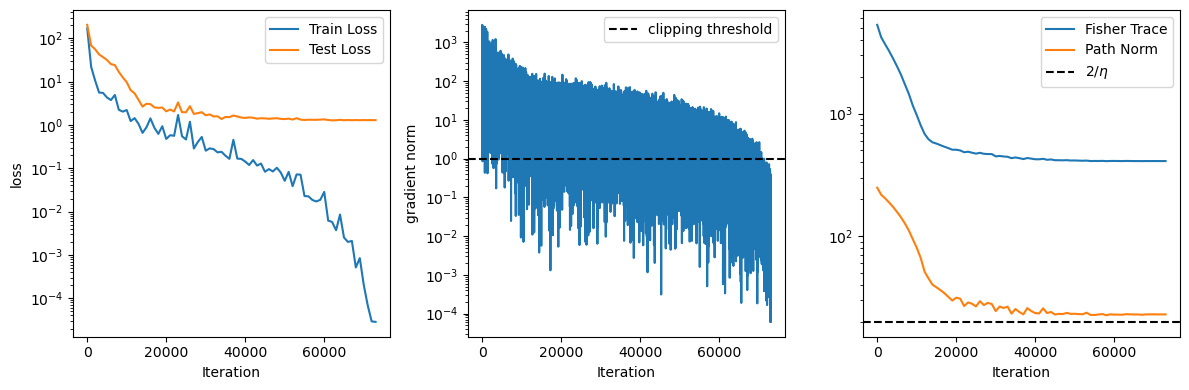

TwoLayerReLU()

In [700]:
train_sgd(lr=1.0 / np.sqrt(d), plot=True)

This is the part where my expiriment diverges from the result of the article. Even with decay of learning rate I couldn't replicate the fast decrease of gradient norm. Also Fisher Trace reached the plateau too high from the $2/\eta$ mark.

In [701]:
lrs = np.logspace(-3, -1, 10)
eta_ref = []
eta_ref_sgd = []
for i in range(len(lrs)):
    eta_ref.append(float(2 / lrs[i]))
    eta_ref_sgd.append(float(2 * np.sqrt(d) / lrs[i]))

In [702]:
sgd_error, gd_error = [], []
sgd_metrics = {
    "trace": [],
    "path_norm": []
}

gd_metrics = {
    "spectral_norm": [],
    "path_norm": []
}

for lr in lrs:
    model_sgd = train_sgd(lr / np.sqrt(d), T=80000, clip=100.0)
    model_gd  = train_gd(lr, T=80000, clip=100.0)

    sgd_error.append(test_error(model_sgd))
    gd_error.append(test_error(model_gd))

    current_sgd_metrics = calculate_metrics(model_sgd, X_train)

    sgd_metrics["trace"].append(current_sgd_metrics[0])
    sgd_metrics["path_norm"].append(current_sgd_metrics[1])

    current_gd_metrics = calculate_metrics(model_gd, X_train)

    gd_metrics["spectral_norm"].append(calculate_spectral_norm(model_gd, X_train))
    gd_metrics["path_norm"].append(current_gd_metrics[1])

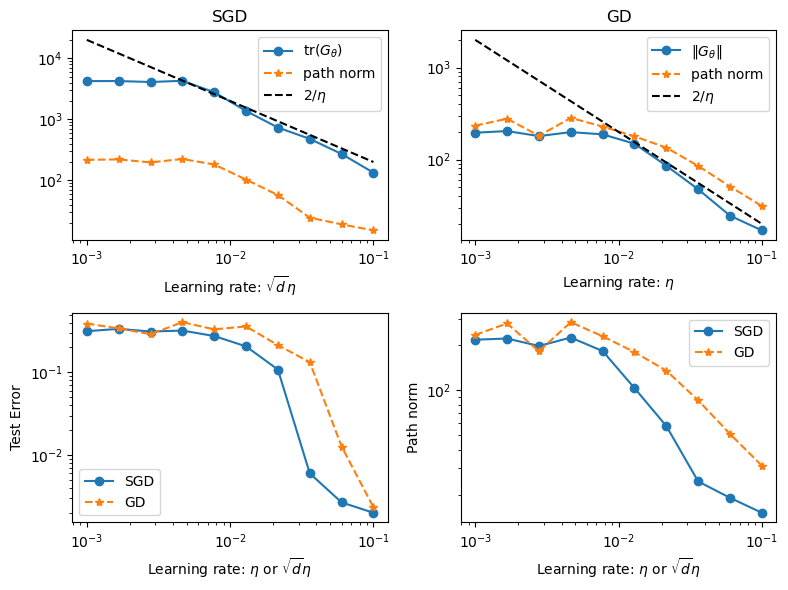

In [703]:
plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.loglog(lrs, sgd_metrics["trace"], "o-", label=r"tr($G_{\theta}$)")
plt.loglog(lrs, sgd_metrics["path_norm"], "*--", label="path norm")
plt.loglog(lrs, eta_ref_sgd, "--", label=r"$2 / \eta$", color="black")
plt.xlabel(r"Learning rate: $\sqrt{d} \eta$")
plt.title("SGD")
plt.legend()

plt.subplot(2, 2, 2)
plt.loglog(lrs, gd_metrics["spectral_norm"], "o-", label=r"$\|G_{\theta}\|$")
plt.loglog(lrs, gd_metrics["path_norm"], "*--", label="path norm")
plt.loglog(lrs, eta_ref, "--", label=r"$2 / \eta$", color="black")
plt.xlabel(r"Learning rate: $\eta$")
plt.title("GD")
plt.legend()

plt.subplot(2, 2, 3)
plt.loglog(lrs, sgd_error, "o-", label="SGD")
plt.loglog(lrs, gd_error, "*--", label="GD")
plt.xlabel(r"Learning rate: $\eta$ or $\sqrt{d} \eta$")
plt.ylabel("Test Error")
plt.legend()

plt.subplot(2, 2, 4)
plt.loglog(lrs, sgd_metrics["path_norm"], "o-", label="SGD")
plt.loglog(lrs, gd_metrics["path_norm"], "*--", label="GD")
plt.xlabel(r"Learning rate: $\eta$ or $\sqrt{d} \eta$")
plt.ylabel("Path norm")
plt.legend()

plt.tight_layout()
plt.show()


This figure shows quite similarly how the sharpness and path norm of minima selected by SGD and GD changes with the LR. For SGD, $\mathrm{Tr}(G(\theta))$ keeps decreasing but close to the upper bound $2/\eta$. For GD, $\|G(\theta)\|$ keeps close to the upper bound $2/\eta$ when the LR is sufficiently large. When the LR is small, the actual sharpness is away from the upper bound. This is the same result that was presented in the article. Additionaly one can see the effect of better generalization of SGD with the increased learning rate compared to GD.
